# Age Recognition Model Notebook using RESNET50

In [1]:
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models
from tensorflow.keras.models import load_model
#from tensorflow.keras.applications.resnet import layers
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, Flatten, MaxPooling2D


In [2]:
# Consts
images = []
ages = []
# Please provide your own image path to the dataface with faces.
path = "../../Datasets/UTKFace"

### Functions

In [3]:
# function to process images before training
def preprocessing(given_img):
    given_img = given_img / 255  # normalizing image.
    given_img = cv2.resize(given_img, (64, 64))  # resizing it.
    return given_img

In [4]:
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, GlobalAveragePooling2D

def create_model(input_shape):
    tf.keras.backend.clear_session()  # clear session before creating model
    input_layer = Input(shape=input_shape)
    base_model = tf.keras.applications.ResNet50(
        include_top=False, weights='imagenet', input_tensor=input_layer
    )
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Conv2D(filters=512, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x)
    x = Dropout(0.5)(x)
    x = Dense(128)(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='linear')(x)
    model = models.Model(inputs=input_layer, outputs=predictions)

    return model

## Training the model

In [5]:
# Loading data
for image in os.listdir(path):
    img = cv2.imread(path + "/" + image)
    images.append(img)
    ages.append(float(image.split("_")[0]))
    
# Splitting the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images, ages, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Convert to NumPy arrays and preprocess the data
X_train = np.array([preprocessing(x) for x in X_train]).reshape(len(X_train), 64, 64, 3)
X_valid = np.array([preprocessing(x) for x in X_valid]).reshape(len(X_valid), 64, 64, 3)
X_test = np.array([preprocessing(x) for x in X_test]).reshape(len(X_test), 64, 64, 3)

y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [6]:
# Creating the model and compile it
input_shape = (64, 64, 3)
model = create_model(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [7]:
tf.config.experimental.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Fitting the model
## history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[stop])
history = model.fit(X_train, y_train, epochs=64, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[stop])

Epoch 1/64
223/223 [==============================] - 36s 104ms/step - loss: 386.8742 - mean_squared_error: 386.8742 - val_loss: 1028.9541 - val_mean_squared_error: 1028.9541
Epoch 2/64
223/223 [==============================] - 9s 41ms/step - loss: 266.2104 - mean_squared_error: 266.2104 - val_loss: 245.3403 - val_mean_squared_error: 245.3403
Epoch 3/64
223/223 [==============================] - 9s 39ms/step - loss: 261.4686 - mean_squared_error: 261.4686 - val_loss: 346.9806 - val_mean_squared_error: 346.9806
Epoch 4/64
223/223 [==============================] - 9s 39ms/step - loss: 260.2197 - mean_squared_error: 260.2197 - val_loss: 261.3872 - val_mean_squared_error: 261.3872
Epoch 5/64
223/223 [==============================] - 9s 40ms/step - loss: 256.8370 - mean_squared_error: 256.8370 - val_loss: 442.3535 - val_mean_squared_error: 442.3535
Epoch 6/64
223/223 [==============================] - 9s 40ms/step - loss: 250.4841 - mean_squared_error: 250.4841 - val_loss: 738.8152 - val

In [9]:
model.save("../../app/models/resnet_trainable.h5")

## Evaluation

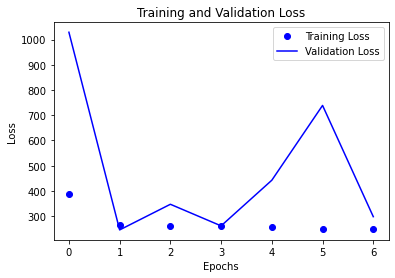

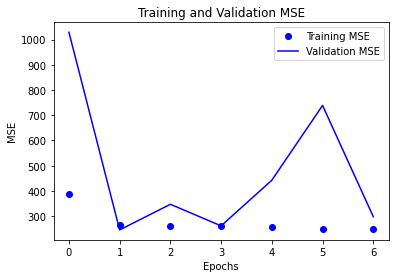

In [10]:
import matplotlib.pyplot as plt

# Plotting the loss
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

epochs = range(len(train_loss))

plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, valid_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy (mean squared error)
train_acc = history.history['mean_squared_error']
valid_acc = history.history['val_mean_squared_error']

epochs = range(len(train_acc))

plt.plot(epochs, train_acc, 'bo', label='Training MSE')
plt.plot(epochs, valid_acc, 'b', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()


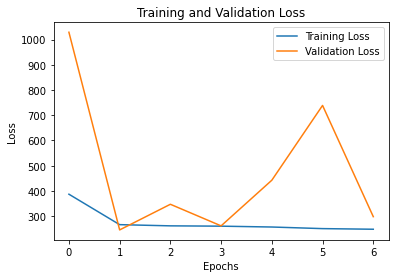

In [11]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
model = load_model("../../app/models/resnet_trainable.h5")

In [13]:
y_pred = model.predict(X_test)

149/149 [==============================] - 4s 15ms/step


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 241.48930423726463
Mean Absolute Error (MAE): 11.977076554422236


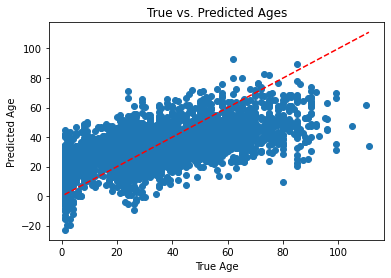

In [15]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('True vs. Predicted Ages')
plt.show()

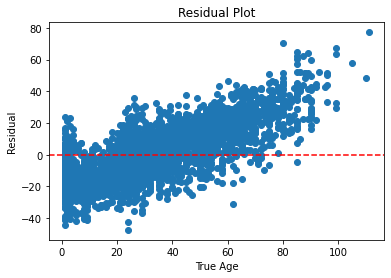

In [16]:
residuals = y_test - y_pred.flatten()
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('True Age')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()

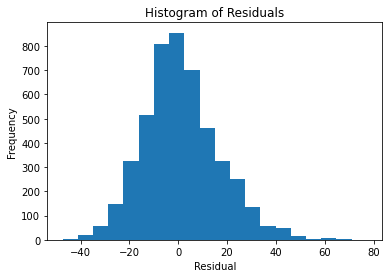

In [17]:
plt.hist(residuals, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

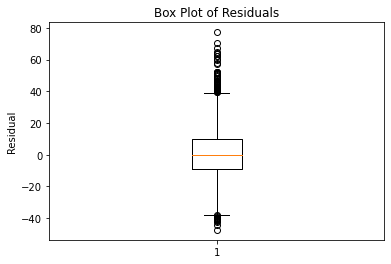

In [18]:
plt.boxplot(residuals)
plt.ylabel('Residual')
plt.title('Box Plot of Residuals')
plt.show()